#

*Gruppe A - Thema 5*

<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/LMU_Muenchen_Logo.svg" alt="Image" width="200" style="float: right;">

### **RL-Policy-Training unter Vermeidung von Zuständen mit sehr geringer Datendichte**


**Dozent:** [Dr. Michel Tokic](https://www.tokic.com/)

**Studenten:** Maximilian Schieder, Leon Lantz

---

## **Aufgabenstellung**

- Erzeugung eines Datensatzes für das Abschätzung der Datendichte

- Sampeln eines Gym-Environments 
    - Entfernen vordefinierter Bereiche, die z.B. durch die eine optimale Policy laufen würde

- Modell-based RL

- Datendichte im Reward abbilden, aber nicht übergewichten

## **Konzept**

1. **Environment auswählen und verstehen** ✅
    - Pendulum-v1
2. **Sampling im Environment** ✅
    - Zustand und entsprechende Aktion jedes Schrittes speichern
3. **Datenbereich herausschneiden** ✅
    - 60-120 Grad (**Ziel**: *Pendel nimmt immer den linken Weg*)
4. **Datendichtemodell erstellen** ✅
    - Kernel Density Estimation 
5. **Model-Based RFL** ✅
    - Window-Size 4, Adaptive Moment Estimation(Adam)-Optimizer
6. **Lernen der Policy mit DDPG** 🔧
    - Modifizierte Reward Function



---

## 📦 **Imports**

- `tensorflow` als `tf` zum Erstellen und Trainieren von maschinellen Lernmodellen

- `numpy` als `np` für numerische Operationen und den Umgang mit Arrays

- `gymnasium` als `gym` zum Erstellen und Interagieren mit Reinforcement Learning-Umgebungen

- `pandas` als `pd` für Datenmanipulation und -analyse

- `matplotlib.pyplot` als `plt` zum Erstellen von Visualisierungen und Diagrammen

- `stable_baselines3.PPO` für Proximal Policy Optimization, einen Reinforcement Learning-Algorithmus

- `stable_baselines3.common.vec_env.DummyVecEnv` zum Erstellen einer Dummy-Vektorisierungsumgebung

- `stable_baselines3.common.vec_env.VecNormalize` zum Normalisieren von Beobachtungen und Belohnungen

- `stable_baselines3.common.monitor.Monitor` zur Überwachung der Trainingsleistung im Reinforcement Learning

- `stable_baselines3.common.results_plotter.load_results` zum Laden von Trainingsergebnissen im Reinforcement Learning

- `stable_baselines3.common.results_plotter.ts2xy` zum Konvertieren von Trainingsergebnissen in Zeitstufen und Werte

- `stable_baselines3.common` für allgemeine Hilfsprogramme und Funktionen in Stable Baselines3

- `os` zum Interagieren mit Betriebssystemfunktionen wie Datei- und Verzeichnisverwaltung

In [27]:
import imageio
import tensorflow as tf
import numpy as np
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
import collections
import os

#for density models
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

#for custom environment
from typing import Optional
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

# Importiere die Funktionen aus der utils.py Datei
from _utils import SaveOnBestTrainingRewardCallback, create_training_data
from custom_environment import Pendulum_Custom_Environment
from custom_environment_density_adjusted_reward import Pendulum_Custom_Environment_DensityAdjustedReward



# Definiere Konstanten für die Spaltennamen
COS_ANGLE = "cosAngle"
SIN_ANGLE = "sinAngle"
ANG_VEL = "angVel"
EPISODE = "episode"
STEP = "step"
ACTION = "action"

In [21]:
class NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self, mean, std, **kwargs):
        super(NormalizeLayer, self).__init__(**kwargs)
        self.mean = tf.constant(mean, dtype=tf.float32)
        self.std = tf.constant(std, dtype=tf.float32)

    def call(self, inputs):
        return (inputs - self.mean) / self.std

    def get_config(self):
        config = super(NormalizeLayer, self).get_config()
        config.update({
            'mean': self.mean.numpy().tolist(),
            'std': self.std.numpy().tolist(),
        })
        return config
    
# Registrieren Sie Ihre benutzerdefinierte Schicht
tf.keras.utils.get_custom_objects()['NormalizeLayer'] = NormalizeLayer

In [ ]:
# Grafikkarte verfügbar?
print(tf.config.list_physical_devices('GPU'))

## 🌍 **Environment**

### <span style="color: red; font-weight: bold;">(Deprecated)</span> 🚗 **Mountain Car**  




<img src="https://gymnasium.farama.org/_images/mountain_car.gif" alt="Mountain Car GIF" width="400" >

Gym Environment -> Mountain Car MDP [**(Documentation)**](https://gymnasium.farama.org/environments/classic_control/mountain_car/)
- **Goal**: Reach the goal state at the top of the right hill
- **Problem**: The car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum
- **Starting Position**: Car starts stochastically at the bottom of a valley

#### **Observation Space**
- 0: position of the car along the x-axis [-1.2, 0.6]
- 1: velocity of the car [-0.07, 0.07]

#### **Action Space**

Discrete deterministic actions
- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right

#### **Reward**

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

#### **Episode End**
- **Termination**: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
- **Truncation**: The length of the episode is 200.

In [ ]:
# for details see: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
CAR_POS = "carPos"
CAR_VEL = "carVel"
EPISODE = "episode"
STEP = "step"
ACTION = "action"


#OPTIONS: Set by User !!!
RENDERED = True
HEURISTIC = False


def heuristic_policy(velocity):
    if velocity >= 0.0:
        return 2 # Accelerate right
    else:
        return 0 # Accelerate left


def sample_data(episodes=1, seed=0):

    if(RENDERED): env = gym.make("MountainCar-v0", render_mode="human")
    else: env = gym.make("MountainCar-v0")
    
    env.reset()

    ### Create empty Pandas dataset
    transitions = []

    ### SAMPLE DATA
    for episode in range(episodes):
        obs = env.reset()
        step = 0
        done = False

        while step < 200 and not done:
            step += 1

            if(step == 1):
                action = env.action_space.sample()
            else:
                if (HEURISTIC): action = heuristic_policy(obs[1])
                else: action = env.action_space.sample()

            obs, reward, done, _, _ = env.step(action)

            transitions.append(
                {
                    CAR_POS: obs[0],
                    CAR_VEL: obs[1],
                    EPISODE: episode,
                    STEP: step,
                    ACTION: action,
                }
            )
        print("Steps: ", step)

    return pd.DataFrame(transitions)

df = sample_data(episodes=100, seed=0)

**Anderer Ansatz:**

-> Reward ändern. z.B. wenn Car halbwegs gute Ergebnisse erzielt (weit oben auf Hügel) Reward +1 setzen

<p style="color: red;">Zustände nahe des Gipfels sind <b>selten, aber wichtig</b> um das Auto in den Gipfelbereich zu bringen. Das Vermeiden solcher Zustände könnte dazu führen, dass das Modell nicht lernt, wie man erfolgreich den Gipfel erreicht.</p>

### <span style="color: red; font-weight: bold;">(Deprecated)</span> 🌑 **Lunar Lander**

<img src="https://www.gymlibrary.dev/_images/lunar_lander.gif" alt="Lunar Lander GIF" width="400" >

Gym Environment -> Lunar Lander [**(Documentation)**](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)

- **Ziel**: Das Ziel besteht darin, den Lander sicher auf dem Landepad zu landen.

- **Ausgangsposition**: Der Lander startet in der oberen Mitte des Ansichtsbereichs mit einer zufälligen Anfangskraft, die auf seinen Schwerpunkt angewendet wird.

#### **Beobachtungsraum**
Der Beobachtungsraum ist ein 8-dimensionaler Vektor
- [0] : x-Koordinate des Landers
- [1] : y-Koordinate des Landers
- [2] : lineare Geschwindigkeit in x-Richtung
- [3] : lineare Geschwindigkeit in y-Richtung
- [4] : Winkel
- [5] : Winkelgeschwindigkeit
- [6] : linkes Bein in Kontakt mit dem Boden (Boolean)
- [7] : rechtes Bein in Kontakt mit dem Boden (Boolean)

#### **Aktionsraum**
Vier diskrete Aktionen
- [0] : nichts tun
- [1] : linke Orientierungsturbine feuern
- [2] : Hauptturbine feuern
- [3] : rechte Orientierungsturbine feuern

#### **Belohnung**
- Die Belohnung erhöht/verringert sich, je näher/weiter der Lander dem Landepad ist.
- Die Belohnung erhöht/verringert sich, je langsamer/schneller sich der Lander bewegt.
- Die Belohnung verringert sich, je mehr der Lander geneigt ist (Winkel nicht horizontal).
- Die Belohnung erhöht sich um 10 Punkte für jedes Bein, das den Boden berührt.
- Die Belohnung verringert sich um 0,03 Punkte für jeden Frame, in dem eine Seitenturbine feuert.
- Die Belohnung verringert sich um 0,3 Punkte für jeden Frame, in dem die Hauptturbine feuert.

#### **Episodenbeendigung**
- Der Lander stürzt ab (der Landerkörper kommt mit dem Mond in Kontakt).
- Der Lander gerät außerhalb des Ansichtsbereichs (x-Koordinate ist größer als 1).
- Der Lander ist nicht wach. Laut den Box2D-Dokumenten ist ein Körper, der nicht wach ist, ein Körper, der sich nicht bewegt und mit keinem anderen Körper kollidiert.

---

In [ ]:
# Setze den Environment Name
environment_name = 'LunarLander-v2'

#### 🌎 **Zufällige Action-Auswahl**

In [ ]:
# Definiere die Anzahl der Episoden für die Bewertung
num_episodes = 100

# Funktion zur Bewertung des Modells
def evaluate(env, num_episodes=100):
    returns = []
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        terminated = False
        total_reward = 0
        while not done and not terminated:
            action = env.action_space.sample()
            state, reward, done, terminated, info = env.step(action)
            total_reward += reward
        returns.append(total_reward)
        #print(f"Episode {episode + 1}: Total Reward: {total_reward}")
    
    # Durchschnittliche Rückgabe berechnen
    average_return = sum(returns) / num_episodes
    print(f"Durchschnittlicher Reward über {num_episodes} Episoden: {average_return}")
    return returns

# Modell bewerten
env = gym.make(environment_name)
returns = evaluate(env, num_episodes=num_episodes)

In [ ]:
env = gym.make(environment_name, render_mode="rgb_array")
episodes = 10

# Funktion zur Aufnahme einer Episode und Speicherung als GIF
for episode in range(episodes):
    output_path = f"results/random/episode_{episode}.gif"
    state, info = env.reset()
    frames = []
    cum_reward = 0
    done = False
    
    while not done:
        # Füge das aktuelle Bild der Frames-Liste hinzu
        frames.append(env.render())
        
        # Zufällige Auswahl einer Aktion
        action = env.action_space.sample()
        state, reward, done, terminated, info = env.step(action)
        cum_reward += reward
    print('Episode:{} Kummulierter Reward:{}'.format(episode, cum_reward))
    
    with imageio.get_writer(output_path, mode='I', duration=0.03) as writer:
        for frame in frames:
            writer.append_data(frame)

env.close()

<p style="color:lightgreen;">Ergebnis:</p>  Bei der Durchführung von zehn Episoden in der <b>Lunar Lander-Umgebung</b>, in denen der Agent zufällig Aktionen auswählt, waren die Ergebnisse erwartungsgemäß schlecht. Der kumulierte Reward ist in der Regel negativ, da zufällige Aktionen selten zu einer erfolgreichen Landung führen. Diese Ergebnisse zeigen deutlich, wie wichtig durchdachte Strategien und gut trainierte Modelle für den Erfolg in komplexen Umgebungen wie Lunar Lander sind.

#### 🏋🏼 **Trainiere ein Modell mit dem A2C-Algorithmus** <b style="color:red;">(Optional)</b>

In [ ]:
env = gym.make(environment_name)
env = DummyVecEnv([lambda: env])
model = A2C('MlpPolicy', env, ent_coef=0.1, verbose=1)
model.learn(total_timesteps=80000)
model.save("models/A2C_model")

#### 👨‍🏫 **Bewertung der Modelle**

In [ ]:
env = gym.make(environment_name)
env = DummyVecEnv([lambda: env])

#del model #optional
#model = A2C.load('models/A2C_model', env=env)
model2 = A2C.load('models/a2c-LunarLander-v2')
# Andere Modelle zur Datengenerierung 

Durchschnitt über 100 Episoden

In [ ]:
# Definiere die Anzahl der Episoden für die Bewertung
num_episodes = 100

# Funktion zur Bewertung des Modells
def evaluate_model(model, env, num_episodes=100):
    returns = []
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        returns.append(total_reward)
        #print(f"Episode {episode + 1}: Total Reward: {total_reward}")
    
    # Durchschnittliche Rückgabe berechnen
    average_return = sum(returns) / num_episodes
    print(f"Durchschnittlicher Reward über {num_episodes} Episoden: {average_return}")
    return returns

# Modell bewerten
returns = evaluate_model(model2, env, num_episodes=num_episodes)

Speichere 10 Episoden als GIF

In [ ]:
env = gym.make(environment_name, render_mode="rgb_array")
env = DummyVecEnv([lambda: env])

episodes = 10

# Funktion zur Aufnahme einer Episode und Speicherung als GIF
for episode in range(episodes):
    output_path = f"results/pretrained_model/episode_{episode}.gif"
    state = env.reset()
    frames = []
    cum_reward = 0
    done = False
    
    while not done:
        # Füge das aktuelle Bild der Frames-Liste hinzu
        frames.append(env.render())
        
        # Vorhersage der Aktion durch das Modell
        action, _states = model.predict(state)
        state, reward, done, info = env.step(action)
        cum_reward += reward
    print('Episode:{} Kummulierter Reward:{}'.format(episode, cum_reward))
    
    with imageio.get_writer(output_path, mode='I', duration=0.03) as writer:
        for frame in frames:
            writer.append_data(frame)

# Schließe das Environment
env.close()

### 🔂 **Pendulum**

<img src="https://www.gymlibrary.dev/_images/pendulum.gif" alt="Mountain Car GIF" width="300">
    

Gym Umgebung -> Pendulum [(Dokumentation)](https://www.gymlibrary.dev/environments/classic_control/pendulum/)  
- **Ziel** : Das Ziel besteht darin, das Pendel aufrecht zu halten (nach oben gerichtet).
 
- **Ausgangsposition** : Das Pendel startet mit einer zufälligen Position und Geschwindigkeit, wobei es meistens nach unten hängt.

**Beobachtungsraum** 

Der Beobachtungsraum ist ein 3-dimensionaler Vektor

- [0] : Kosinus des Winkels (cos(θ))

- [1] : Sinus des Winkels (sin(θ))

- [2] : Winkelgeschwindigkeit

<img src=".\Sinus_und_Kosinus_am_Einheitskreis_pendulum.png" alt="Einheitskreis" width="200">

**Aktionsraum** 

Eine kontinuierliche Aktion

- Eine Kraft (Drehmoment) zwischen -2 und 2 wird auf das Pendel ausgeübt.

**Belohnung**  

- Die Belohnung ist definiert als:
`-(θ^2 + 0.1 * θ_dot^2 + 0.001 * action^2)`

Dabei ist `θ` der Winkel des Pendels, `θ_dot` die Winkelgeschwindigkeit und `action` das ausgeübte Drehmoment.

- Die Belohnung ist umso geringer (negativer), je weiter das Pendel von der aufrechten Position entfernt ist und je größer die Geschwindigkeit und das aufgebrachte Drehmoment sind.

**Episodenbeendigung** 
- Eine Episode endet nach 200 Zeitschritten.


---

#### 🌎 **Zufällige Altion-Auswahl**

In [ ]:
NUM_EPISODES = 100

# Funktion zur Bewertung des Modells
def evaluate(env, num_episodes=100):
    returns = []
    
    for episode in range(NUM_EPISODES):
        state, info = env.reset()
        done = False
        terminated = False
        total_reward = 0
        
        while not done and not terminated:
            action = env.action_space.sample()
            state, reward, done, terminated, info = env.step(action)
            total_reward += reward
        
        returns.append(total_reward)
    
    # Durchschnittliche Rückgabe berechnen
    average_return = sum(returns) / num_episodes
    print(f"Durchschnittlicher Reward über {num_episodes} Episoden: {average_return}")
    
    return returns

env = gym.make('Pendulum-v1')
returns = evaluate(env, num_episodes=NUM_EPISODES)

Zufälliges Samplen anzeigen (PyGame):

In [ ]:
NUM_EPISODES = 1

# Erstelle die Umgebung mit Rendering-Modus "human"
env = gym.make('Pendulum-v1', render_mode="human")

# Liste zum Speichern der Gesamt-Belohnungen jeder Episode
returns = []

# Durchlaufe die festgelegte Anzahl an Episoden
for episode in range(NUM_EPISODES):
    state, info = env.reset()  # Umgebung zurücksetzen
    done = False
    total_reward = 0

    # Solange die Episode nicht beendet ist, führe Aktionen aus
    while not done:
        action = env.action_space.sample()  # Wähle zufällige Aktion
        state, reward, done, terminated, info = env.step(action)
        done = done or terminated  # Beende die Episode, falls sie abgeschlossen oder terminiert ist
        total_reward += reward  # Sammle die Gesamtbelohnung

    returns.append(total_reward)  # Speichere die Belohnung der Episode
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

# Schließe die Umgebung nach den Episoden
env.close()

## 💿 **Daten-Sampling**

In [22]:
def sample_data(episodes=10000):
    # Erstelle die Pendulum-Umgebung
    env = gym.make("Pendulum-v1")
    
    # Erstelle eine leere Liste zum Speichern der Übergänge (Transitions)
    transitions = []

    # Daten sammeln
    for episode in range(episodes):
        obs, _ = env.reset()
        step = 0
        done = False

        while not done:
            step += 1
            action = env.action_space.sample()

            transitions.append({COS_ANGLE: obs[0], SIN_ANGLE: obs[1], 
                                ANG_VEL: obs[2], EPISODE: episode, 
                                STEP: step, ACTION: action[0]})

            obs, reward, done, terminated, _ = env.step(action)
            done = done or terminated  # Beende, wenn die Episode abgeschlossen oder terminiert ist

    # Konvertiere die Liste der Übergänge in ein Pandas DataFrame
    return pd.DataFrame(transitions)


In [34]:
# Sample data
df = sample_data(episodes=200)
print("Länge: ", len(df))
print(60*"-")
print(df.head())

Länge:  40000
------------------------------------------------------------
   cosAngle  sinAngle    angVel  episode  step    action
0  0.894097 -0.447873  0.525912        0     1  1.163137
1  0.902110 -0.431506  0.364477        0     2 -0.390870
2  0.901726 -0.432308 -0.017782        0     3 -0.783577
3  0.891556 -0.452911 -0.459550        0     4  1.153374
4  0.876940 -0.480600 -0.626227        0     5 -1.542007


In [ ]:
df.dtypes

In [ ]:
df.plot(subplots=True, figsize=(10,15), grid=True)

In [ ]:
# 2D-Histogramm von cosAngle vs sinAngle
plt.figure(figsize=(10, 7))
h = plt.hist2d(df[COS_ANGLE], df[SIN_ANGLE], bins=40, norm=LogNorm(), cmap='Reds')
plt.colorbar(h[3])
plt.grid(True)
plt.xlabel("Cosinus des Winkels")
plt.ylabel("Sinus des Winkels")
plt.title("2D-Histogramm von Cosinus vs Sinus des Winkels")
plt.show()

## ✂️ **Daten ausschneiden**

Die Werte in folgendem Bild dienen nur als Orientierung für das Winkel zu Bogenmaß Verhältnis, dies muss gemäß der Definition des Pendulum Environmens aber abgewandelt werden. Wir wollen dann den Winkelbereich [+60°, +120°] herausfiltern, um diesen Bereich für das Modell unbekannt zu machen.

Wir schneiden den folgenden Bereich aus den Daten:
( $\frac{1}{2}$ , $\frac{\sqrt{3}}{2}$ ) bis ($-\frac{1}{2}$ ,$\frac{\sqrt{3}}{2}$ ) (vgl. Abb. unten, wobei die Abbildung gedreht werden muss --> custom Abbildung folgt noch). 

![EInheitskreis](./Einheitskreis_Winkel.png)  

Beachte, das Bogenmaß ist hier anders definiert. Nach dem Pendulum Environment ist 0° definiert als das Pendel in der upright position.
Damit sind alle anderen Werte von *theta* im Intervall [$-\pi$, $\pi$]. Positive Werte deuten eine Position im rechten Bereich des Pendulumkreises an, negative wiederum deute auf eine aktuelle Position im linken Bereich des Pendulumkreises an.


In [24]:
# Berechne den Winkel (theta) basierend auf den x- und y-Werten
df['theta_winkel'] = np.arctan2(df[SIN_ANGLE], df[COS_ANGLE])

### Datenanalyse (optional)
    #print(df.head())
    #print(df[COS_ANGLE].max())
    #print(df[COS_ANGLE].min())
    #print(df[SIN_ANGLE].max())
    #print(df[SIN_ANGLE].min())
    #print(df['theta_winkel'].max())
    #print(df['theta_winkel'].min())
    #df['theta_rounded'] = np.round(df['theta_winkel'], decimals=3)
    #print(df[df['theta_rounded'] == 0])

### Definiere die Winkelgrenzen
lower_bound_theta_winkel = np.pi / 3        # +60°
upper_bound_theta_winkel = 2 * np.pi / 3   # +120°

### Filter für den Bereich auf dem Einheitskreis
cut_out_df = df[(df['theta_winkel'] <= lower_bound_theta_winkel) | (df['theta_winkel'] >= upper_bound_theta_winkel)]
print(len(cut_out_df))
print(cut_out_df.head())


34117
   cosAngle  sinAngle    angVel  episode  step    action  theta_winkel
0 -0.850819 -0.525459 -0.930545        0     1 -0.608537     -2.588338
1 -0.885857 -0.463959 -1.415920        0     2  1.853927     -2.659134
2 -0.917849 -0.396929 -1.485800        0     3 -0.216766     -2.733424
3 -0.950060 -0.312067 -1.816012        0     4  0.635351     -2.824224
4 -0.975978 -0.217869 -1.954759        0     5 -1.038895     -2.921962


In [25]:
### Check um richtiges cutten zu gewährleisten nur als Check
cut_out_df_check = df[(df['theta_winkel'] > lower_bound_theta_winkel) & (df['theta_winkel'] < upper_bound_theta_winkel)]
print(cut_out_df_check.head())
print(len(cut_out_df_check))

### Weiterführende Analyseoptionen
    #print(lower_bound_theta_winkel)
    #print(upper_bound_theta_winkel)
    #Kontrolle der x und y Koordinaten
    #print(cut_out_df_check[COS_ANGLE].min())
    #print(cut_out_df_check[COS_ANGLE].max())
    #print(cut_out_df_check[SIN_ANGLE].min())
    #zur Kontrolle müssen die Ergebnisse folgendes aufweisen: 
    #cosAngle im Intervall [-0.5, 0.5] und sinAngle > sqrt(3)/2 = 0.866

     cosAngle  sinAngle    angVel  episode  step    action  theta_winkel
200 -0.329260  0.944239  0.967786        1     1 -0.156914      1.906317
201 -0.406063  0.913845  1.652428        1     2 -1.921527      1.988938
202 -0.497419  0.867511  2.049583        1     3  1.329005      2.091417
232 -0.374442  0.927250 -2.994478        1    33  0.017731      1.954592
233 -0.265745  0.964043 -2.296381        1    34 -0.801592      1.839773
5883


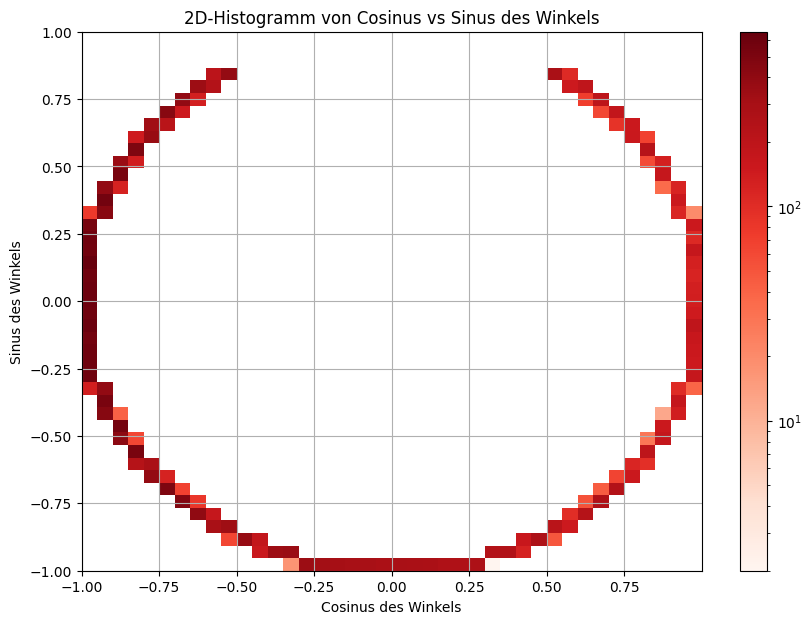

In [26]:
# 2D-Histogramm von cosAngle vs sinAngle
plt.figure(figsize=(10, 7))
h = plt.hist2d(cut_out_df[COS_ANGLE], cut_out_df[SIN_ANGLE], bins=40, norm=LogNorm(), cmap='Reds')
plt.colorbar(h[3])
plt.grid(True)
plt.xlabel("Cosinus des Winkels")
plt.ylabel("Sinus des Winkels")
plt.ylim(-1, 1)  # Beschränkung der y-Achse
plt.title("2D-Histogramm von Cosinus vs Sinus des Winkels")
plt.show()

## 📊 **Datendichte**

### Kernel Density Estimation Model
Das Datendichtemodell wird als Kernel Density Estimation umgesetzt.  
Im Folgenden wird insbesondere auch der optimale bandwith-Parameter für die Kernel Density Estimation betrachtet.  
Außerdem werden verschieden Methoden zur Visualisierung eingesetzt.  
Mit folgendem Datendichtemodell *kde* kann für die generierten Daten die Datendichte berechnet werden. Diese Datendichtemodell kann daraufhin auf alle Daten bzw auch neu gesampelte Daten angewendet werden. Insbesondere ist keine neue Berechnung des Datendichtemodells notwendig.


In [ ]:
## Kernel Density Modell (rausgecuttete Daten werden berücksichtigt)
# features: die betrachteten Parameter, für die eine Datendichte berechnet werden soll
features = cut_out_df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]

# KDE model
kde = KernelDensity(kernel='gaussian', bandwidth = 0.1)  # optimal bandwidth will be determined below
kde.fit(features)
log_density = kde.score_samples(features)
density = np.exp(log_density)
cut_out_df['kde_density'] = density

#plots for visualisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cut_out_df[COS_ANGLE]
y = cut_out_df[SIN_ANGLE]
z = cut_out_df['kde_density']

ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel(COS_ANGLE)
ax.set_ylabel(SIN_ANGLE)
ax.set_zlabel('Density')
plt.title('3D KDE-Plot')
plt.show()
cut_out_df.head()


#### Bestimmen des optimalen bandwith Parameters


##### Cross Validation
Testen auf verschieden Bandwith Parameter. Bewertung durch den GridSearchCV Algorithmus (cross validation, 5-fold, betrachtet nur den mean)  
Alternative Bewertung anhand des Qutienten von Mittelwert (wie gut fittet das Modell) und Standardabweichung (wie stabil ist das Modell)

In [ ]:
features = cut_out_df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]
bandwidths = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]


# GridSearchCV zur Bandwidth-Optimierung
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold is default value

grid.fit(features)

best_bandwidth = grid.best_params_['bandwidth']
print(f'Optimale Bandwidth: {best_bandwidth}')

# anschauliche Ausgabe der Ergebnisse
cv_results = grid.cv_results_

mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']
bandwidths = cv_results['param_bandwidth']

# Berechne den Quotienten als Alternative zur Bewertung der optimalen Bandwith
quotients = mean_scores / std_scores

# Erstelle ein DataFrame zur übersichtlichen Darstellung
results_df = pd.DataFrame({
    'Bandwidth': bandwidths,
    'Mean Score': mean_scores,
    'Std Score': std_scores,
    'Mean / Std Quotient': quotients
})
print(results_df)

##### kdeplot (seaborn)
Anhand des Plots kann durch Visualisierung ein passender bandwith parameter gefunden werden. Insbesondere soll sowohl overfitting als auch underfitting vermieden werden.

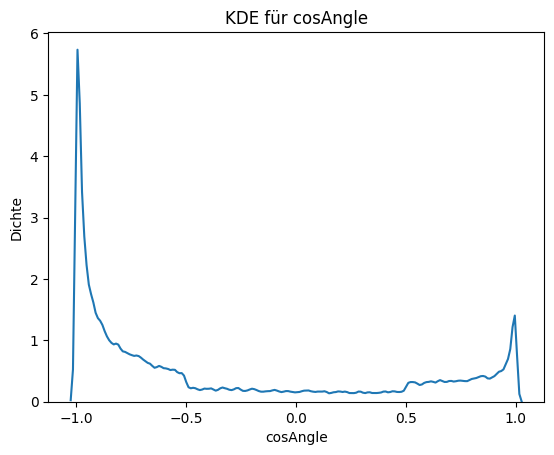

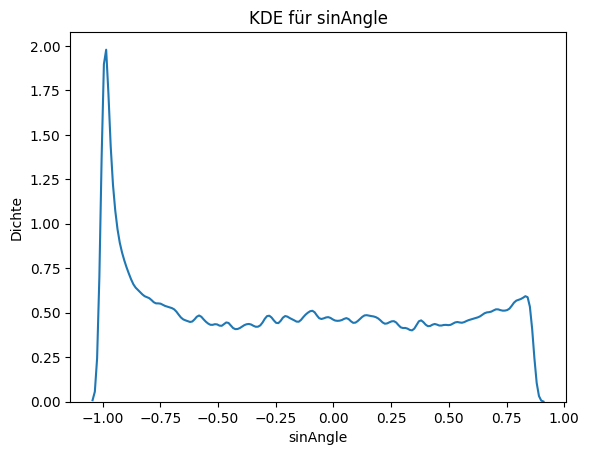

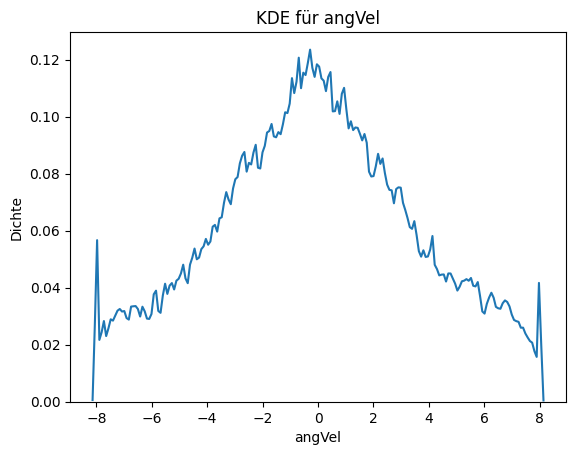

In [37]:
#plot Density for both parameters
sns.kdeplot(cut_out_df[COS_ANGLE], bw_adjust=0.1)
plt.title('KDE für cosAngle')
plt.xlabel('cosAngle')
plt.ylabel('Dichte')
plt.show()

sns.kdeplot(cut_out_df[SIN_ANGLE], bw_adjust=0.2)
plt.title('KDE für sinAngle')
plt.xlabel('sinAngle')
plt.ylabel('Dichte')
plt.show()

sns.kdeplot(cut_out_df[ANG_VEL], bw_adjust=0.1)
plt.title('KDE für angVel')
plt.xlabel('angVel')
plt.ylabel('Dichte')
plt.show()

#### Datendichtemodell (kde) auf neue Daten anwenden

In [ ]:
features = df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]

# Berechne die Dichte für die gesampelten Daten
log_density = kde.score_samples(features)
density_sampled_data = np.exp(log_density)
df['kde_density'] = density_sampled_data

#print(df)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df[COS_ANGLE]
y = df[SIN_ANGLE]
z = df['kde_density']

ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel(COS_ANGLE)
ax.set_ylabel(SIN_ANGLE)
ax.set_zlabel('Density')
plt.title('3D KDE-Plot')
plt.show()
df.head()

### Gaussian Mixture Model

C:\Users\Maximilian Schieder\AppData\Local\Temp\ipykernel_12868\2122580540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_out_df['gmm_density'] = density


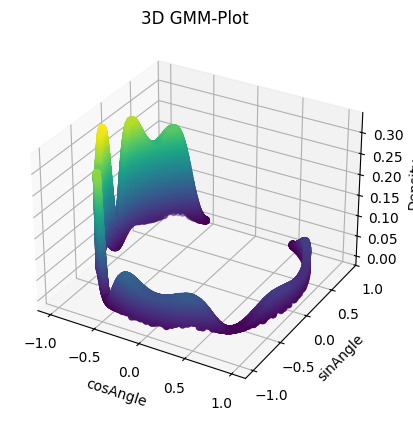

,cosAngle,sinAngle,angVel,episode,step,action,theta_winkel,gmm_density
0,-0.850819,-0.525459,-0.930545,0,1,-0.608537,-2.588338,0.234621
1,-0.885857,-0.463959,-1.415920,0,2,1.853927,-2.659134,0.224629
2,-0.917849,-0.396929,-1.485800,0,3,-0.216766,-2.733424,0.242413
3,-0.950060,-0.312067,-1.816012,0,4,0.635351,-2.824224,0.276047
4,-0.975978,-0.217869,-1.954759,0,5,-1.038895,-2.921962,0.277085


In [32]:
# Parameter, mit denen das Dichtemodell berechnet werden soll
features = cut_out_df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]

#GMM model
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm.fit(features)
log_density = gmm.score_samples(features)
density = np.exp(log_density)
cut_out_df['gmm_density'] = density

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cut_out_df[COS_ANGLE]
y = cut_out_df[SIN_ANGLE]
z = cut_out_df['gmm_density']

ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel(COS_ANGLE)
ax.set_ylabel(SIN_ANGLE)
ax.set_zlabel('Density')
plt.title('3D GMM-Plot')
plt.show()
cut_out_df.head()

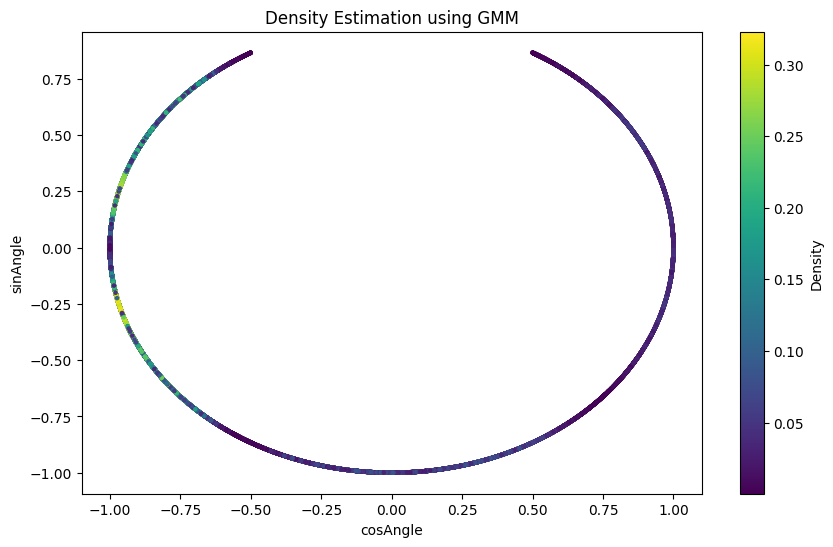

In [33]:
# Optionale Visualisierung des GMM
plt.figure(figsize=(10, 6))
plt.scatter(cut_out_df[COS_ANGLE], cut_out_df[SIN_ANGLE], c=cut_out_df['gmm_density'], cmap='viridis', s=5)
plt.colorbar(label='Density')
plt.xlabel(COS_ANGLE)
plt.ylabel(SIN_ANGLE)
plt.title('Density Estimation using GMM')
plt.show()

#### Parameter für die Anzahl der Gaußverteilungen bestimmen
Durch Tests kann bestimmt werden, wie viele Gaußverteilungen als zugrundliegende Verteilungen angenommen werden sollen

##### AIC/BIC Tradeoff
Um zu testen welche n_components verwendet werden sollten: Ansatz mit Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC). Daraus wird der Punkt abgelesen, ab dem die Kurve abflacht und dieser n value kann angenommen werden.


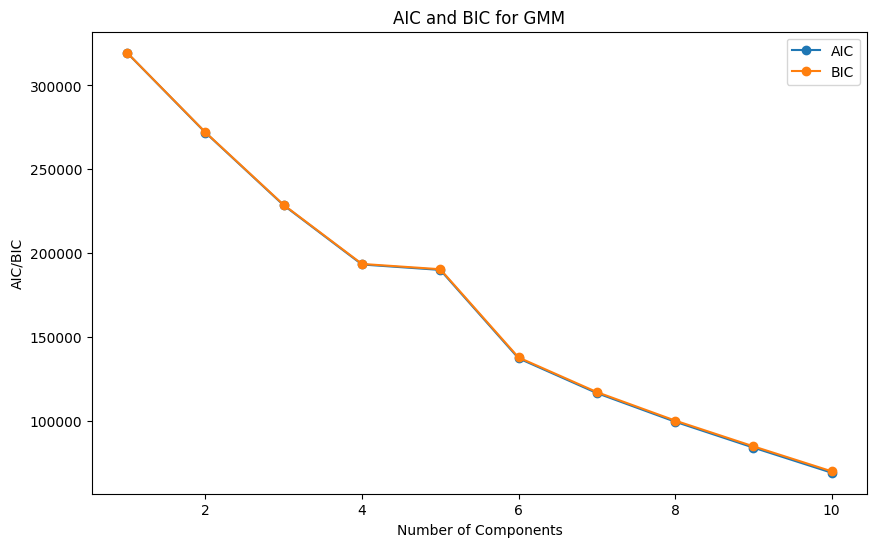

In [31]:
aic = []
bic = []

# verschieden Anzahlen an Gaußverteilungen testen
n_components_range = range(1, 11)
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
    gmm.fit(features)
    aic.append(gmm.aic(features))
    bic.append(gmm.bic(features))

# Plotting AIC and BIC
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, aic, label='AIC', marker='o')
plt.plot(n_components_range, bic, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('AIC/BIC')
plt.title('AIC and BIC for GMM')
plt.legend()
plt.show()

#### Datendichtemodell (gmm) auf neue Daten anwenden

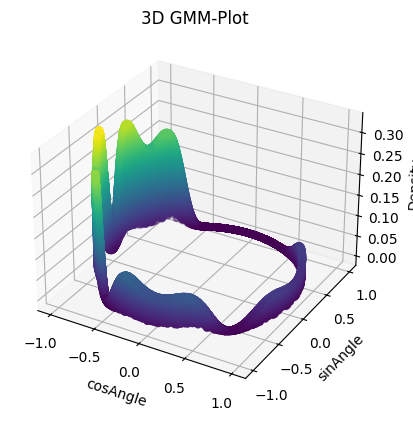

,cosAngle,sinAngle,angVel,episode,step,action,gmm_density
0,0.894097,-0.447873,0.525912,0,1,1.163137,0.037533
1,0.902110,-0.431506,0.364477,0,2,-0.390870,0.041109
2,0.901726,-0.432308,-0.017782,0,3,-0.783577,0.042125
3,0.891556,-0.452911,-0.459550,0,4,1.153374,0.038190
4,0.876940,-0.480600,-0.626227,0,5,-1.542007,0.032415


In [35]:
features = df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]

# Berechne die Dichte für die gesampelten Daten
log_density = gmm.score_samples(features)
density_sampled_data = np.exp(log_density)
df['gmm_density'] = density_sampled_data

#Plotten
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df[COS_ANGLE]
y = df[SIN_ANGLE]
z = df['gmm_density']

ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel(COS_ANGLE)
ax.set_ylabel(SIN_ANGLE)
ax.set_zlabel('Density')
plt.title('3D GMM-Plot')
plt.show()
df.head()

## 🗺️ **Model Based RL**

### 🏋️ Training das Zustandsübergangsmodells

In [ ]:
window_size=4
input_col = [COS_ANGLE, SIN_ANGLE, ANG_VEL, ACTION]
target_col = [COS_ANGLE, SIN_ANGLE, ANG_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            utils.prepare_data(df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

In [11]:
def build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape, optimizer=tf.keras.optimizers.Adam()):

    print(f"mean in = {mean_in}, std in = {std_in}, mean out = {mean_out}, std out = {std_out}")

    single_step_model = tf.keras.models.Sequential()
    
    # Verwende die benutzerdefinierte Standardisierungsschicht
    single_step_model.add(NormalizeLayer(mean=mean_in, std=std_in, input_shape=input_shape))
    single_step_model.add(tf.keras.layers.LSTM(50, input_shape=input_shape, dtype=np.float32))
    single_step_model.add(tf.keras.layers.Dense(len(mean_out), activation="linear"))

    single_step_model.compile(optimizer=optimizer, loss="mse")

    return single_step_model

In [ ]:
modelpath = "model.keras"
max_epochs = 2500
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

# Callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=250, restore_best_weights=True, verbose=True)
mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s_bestTrainLoss.keras" % modelpath, monitor='loss', verbose=1, save_best_only=True, mode='min')
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s_bestValLoss.keras" % modelpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./model_logs_tb", histogram_freq=1)

# Modell erstellen
step_model = build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape)

# Modell trainieren
history = step_model.fit(train_data, epochs=max_epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_data, validation_steps=validation_steps, validation_freq=validation_freq,
                        callbacks=[mc_trainLoss_callback, mc_valLoss_callback, es_callback, tensorboard_callback])

# Modell speichern
step_model.save(modelpath)

### 🧪 Modellevaluation

In [9]:
dfEval = sample_data(episodes=1)
dfEval = dfEval[dfEval.episode==0]

In [ ]:
window_size=4
output_min = [-1, -1, -8]
output_max = [1, 1, 8]

# Modell laden
model = tf.keras.models.load_model("model.keras_bestValLoss.keras", compile=False)

# FIFO-Puffer, der den Zustand des neuronalen Netzes speichert
stateBuffer = collections.deque(maxlen=window_size)

# Ausgaben des neuronalen Netzwerks werden hier gespeichert
transitions = []

for i in range(len(dfEval)): 
                            
    # Schätzung des ersten Zustands
    if i < window_size: 
        state_data = np.float32([dfEval[COS_ANGLE].values[i], dfEval[SIN_ANGLE].values[i],
                               dfEval[ANG_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
    
    # Vorhersage des nachfolgenden Zustands
    else: 
        
        state = np.array([list(stateBuffer)])
        if i==5:
            print(state)
        netOutput = model.predict(np.float32(state))[0]

        # Überprüfen, ob eine Begrenzung überschritten wurde
        if np.any(netOutput < output_min) or np.any(netOutput > output_max):
            print ("Begrenzung überschrritten bei Schritt: ", i)
            print(netOutput)
        
        # Begrenzung der Ausgabe auf begrenzenden Datenbereich
        netOutput = np.clip(netOutput, output_min, output_max)
        
        ##########################
        # Sollten wir bei der Begrenzung wegen Sinus und Kosinus nicht kleiner/größer ohne Gleich verwenden?
        #######################

        # Daten zum Plotten hinzufügen
        transitions.append({
            COS_ANGLE: netOutput[0], SIN_ANGLE: netOutput[1],
            ANG_VEL: netOutput[2]
        })
        
        # RNN-Zustand aktualisieren
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], 
                                       dfEval[ACTION].values[i]]))
        
dfNet = pd.DataFrame(transitions)


In [ ]:
fig, axs = plt.subplots (4, 1, figsize=(10,8))

fields = [COS_ANGLE, SIN_ANGLE, ANG_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(dfNet)), dfEval[f].values[window_size:window_size+len(dfNet)], label=f)
    axs[i].plot(range (len(dfNet)), dfNet[f].values, label="prediction", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[3].plot(range (len(dfNet)), dfEval[ACTION].values[window_size:window_size+len(dfNet)], label=ACTION)
axs[3].grid()
axs[3].legend(loc="best")


## 👣 **Policies trainieren**

### **Deep Deterministic Policy Gradient (DDPG)**

#### **Default**

In [3]:
log_dir = "logs_modelBased_DDPG"
os.makedirs(log_dir, exist_ok=True)

In [6]:
env = Pendulum_Custom_Environment(model_filename="model.keras", window_size=4)
env = Monitor(env, log_dir) # required for using callback functions during training
env = DummyVecEnv([lambda: env]) # optionally state normalization
env = VecNormalize(env, norm_obs=True, norm_reward=True) # State normalization
env.render_mode = None

In [ ]:
from stable_baselines3.ddpg import MlpPolicy

# Define the model
model_ddpg = DDPG(MlpPolicy, env, verbose=1, device="auto")

# Define the callback
callback_ddpg = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, avg_episodes=30, vec_norm_env=env)

# Train the model
model_ddpg.learn(total_timesteps=50000, callback=callback_ddpg)

# Save the model
model_ddpg.save(os.path.join(log_dir, 'ddpg_model'))

# Save normalization parameters
env.save(os.path.join(log_dir, 'ddpg_env_normalizations'))

# Close the environment
env.close()

#### **DDPG_Reward**

In [10]:
log_dir = "logs_modelBased_DDPG_reward3"
os.makedirs(log_dir, exist_ok=True)

In [11]:
env = Pendulum_Custom_Environment_DensityAdjustedReward(model_filename="model.keras", window_size=4, reward_function_id=3, kde=kde)
env = Monitor(env, log_dir) # required for using callback functions during training
env = DummyVecEnv([lambda: env]) # optionally state normalization
env = VecNormalize(env, norm_obs=True, norm_reward=True) # State normalization
env.render_mode = None

In [ ]:
from stable_baselines3.ddpg import MlpPolicy

# Define the model
model_ddpg = DDPG(MlpPolicy, env, verbose=1, device="cuda")

# Define the callback
callback_ddpg = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, avg_episodes=30, vec_norm_env=env)

# Train the model
model_ddpg.learn(total_timesteps=50000, callback=callback_ddpg)

# Save the model
model_ddpg.save(os.path.join(log_dir, 'ddpg_model'))

# Save normalization parameters
env.save(os.path.join(log_dir, 'ddpg_env_normalizations'))

# Close the environment
env.close()

### **Soft Actor Critic (SAC)**

In [3]:
log_dir = "logs_modelBased_SAC"
os.makedirs(log_dir, exist_ok=True)

In [4]:
env = Pendulum_Custom_Environment(model_filename="model.keras", window_size=4)
env = Monitor(env, log_dir) # required for using callback functions during training
env = DummyVecEnv([lambda: env])# optionally state normalization
env = VecNormalize(env, norm_obs=True, norm_reward=True) # State normalization
env.render_mode = None

In [ ]:
from stable_baselines3.sac import MlpPolicy

# Define the model
model_sac = SAC(MlpPolicy, env, verbose=1, device="cuda")

# Define the callback
callback_sac = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, avg_episodes=30, vec_norm_env=env)

# Train the model
model_sac.learn(total_timesteps=70000, callback=callback_sac)

# Save the model
model_sac.save(os.path.join(log_dir, 'sac_model'))

# Save normalization parameters
env.save(os.path.join(log_dir, 'sac_env_normalizations'))

# Close the environment
env.close()

###  **Asynchronous Advantage Actor Critic (A3C)**

In [5]:
log_dir = "logs_modelBased_A2C"
os.makedirs(log_dir, exist_ok=True)

In [6]:
env = Pendulum_Custom_Environment(model_filename="model.keras", window_size=4)
env = Monitor(env, log_dir) # required for using callback functions during training
env = DummyVecEnv([lambda: env])# optionally state normalization
env = VecNormalize(env, norm_obs=True, norm_reward=True) # State normalization
env.render_mode = None

In [ ]:
from stable_baselines3.a2c import MlpPolicy

# Define the model
model_a2c = A2C(MlpPolicy, env, verbose=1, device="cuda")

# Define the callback
callback_a2c = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, avg_episodes=30, vec_norm_env=env)

# Train the model
model_a2c.learn(total_timesteps=100000, callback=callback_a2c)

# Save the model
model_a2c.save(os.path.join(log_dir, 'a2c_model'))

# Save normalization parameters
env.save(os.path.join(log_dir, 'a2c_env_normalizations'))

# Close the environment
env.close()

## 👩‍🔬 **Policies evaluieren** 

In [ ]:
# um sicherzustellen, welche trainierte Policy wir laden, da log_dir für jedes Training neu gesetzt wird
#log_dir = "logs_modelBased_DDPG"
#log_dir = "logs_modelBased_SAC"
#log_dir = "logs_modelBased_A2C"
log_dir = "logs_modelBased_DDPG_reward3"
print (log_dir)

Ergebnisse plotten

In [ ]:
time_steps = 100000
results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "%s modelBased Learning Pendulum" % log_dir.split('_')[-1])
plt.savefig("%s/graph.png" % log_dir)
plt.show()

Anwenden der Policies auf das originale Environment

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Change (...).load 
# DDPG, SAC, A2C
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#best_policy_modelBased = DDPG.load("%s/ddpg_model.zip" % log_dir)
#best_policy_modelBased = SAC.load("%s/sac_model.zip" % log_dir)
#best_policy_modelBased = A2C.load("%s/a2c_model.zip" % log_dir)
best_policy_modelBased = DDPG.load("%s/best_model.zip" % log_dir)

## Wählen, ob wir mit rendering testen wollen
## Falls wir ohne rendern testen:
#env = DummyVecEnv([lambda: gymmake("Pendulum-v1")])
## Falls wir mit rendern testen 

# None oder human
render_mode = None

env = DummyVecEnv([lambda: gym.make("Pendulum-v1", render_mode = render_mode)])

# Load the saved statistics
#env = VecNormalize.load("%s/ddpg_env_normalizations" % log_dir, env)
#env = VecNormalize.load("%s/sac_env_normalizations" % log_dir, env)
#env = VecNormalize.load("%s/a2c_env_normalizations" % log_dir, env)
env = VecNormalize.load("%s/best_model.env_normalizations" % log_dir, env)


 # Wichtiger Schritt, um die Normalisierung während der Evaluierung nicht anzupassen
env.training=False

## hier können wir setzen, welche Werte wir normalisieren wollen (je nach Bedarf auskommentieren)
## wenn wir die Normalisierung ausstellen, können wir die Werte mit der reward funktion replizieren!! 
## --> dann funktioniert aber das Model nicht, da wir für die Prediction die normalisierten states brauchen

#hier können wir mit False die Werte aus dem Trainingsgraphen vergleichen
env.norm_reward = False

#diese Option würde die States nicht normalisieren, damit kann der reward zwar formeltechnisch berechnet werden, aber wir haben keine richtige policy mehr
env.norm_obs = True

##Falls wir mehrfach ausführen wollen, dann mit for i in range
transitions = []

# Funktion zum Denormalisieren der Observations
def denormalize_obs(normalized_obs, env):
    obs_mean = env.obs_rms.mean  # Mittelwert der Observations
    obs_std = env.obs_rms.var ** 0.5  # Standardabweichung (Varianz^0.5)
    return normalized_obs * obs_std + obs_mean  # Denormalisierte Observations

NUM_EPISODES = 200

for episode in range (NUM_EPISODES): 
    state = env.reset()
    done=False
    cumReward = 0
    steps=0

    while not done: 
        steps += 1
        action, _states = best_policy_modelBased.predict(state)
        state, reward, done, _ = env.step(action)
        if done: 
            print (f"Episode {episode} terminated after {steps} steps")
        #done können wir rausschmeißen glaub ich

        denorm_state = denormalize_obs(state[0], env)

        transitions.append({COS_ANGLE: denorm_state[0], SIN_ANGLE: denorm_state[1], 
                                ANG_VEL: denorm_state[2], EPISODE: episode, 
                                STEP: steps, ACTION: action[0]})
        
        cumReward += reward

        env.render() ## <- comment out in Google colab

    print ("steps=%d, cumReward=%.3f" % (steps, cumReward))
env.close()

df = pd.DataFrame(transitions)

In [ ]:
# 2D-Histogramm von cosAngle vs sinAngle
plt.figure(figsize=(10, 7))
h = plt.hist2d(df[COS_ANGLE], df[SIN_ANGLE], bins=40, norm=LogNorm(), cmap='Reds')
plt.colorbar(h[3])
plt.grid(True)
plt.xlabel("Cosinus des Winkels")
plt.ylabel("Sinus des Winkels")
plt.ylim(-1, 1)  # Beschränkung der y-Achse
plt.xlim(-1, 1)  # Beschränkung der y-Achse
plt.title("2D-Histogramm von Cosinus vs Sinus des Winkels")
plt.show()

---
# **Autoren**: Maximilian Schieder, Leon Lantz